
# NLP Text Classification Project

## Project Overview
This project demonstrates an end-to-end Natural Language Processing (NLP) workflow for text classification.
The objective is to preprocess raw text data, extract meaningful features, and train a machine learning model
to predict text categories.

This notebook is structured to clearly explain each step, following professional data science practices.



## Dataset Description
The dataset contains textual data along with corresponding labels.
Each row represents a text sample used for supervised learning.

**Target:** Text category  
**Input:** Raw text


In [23]:

# Import required libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score



## Data Loading
Load the dataset and perform initial inspection.


In [24]:

# Load dataset (update the path if needed)
df = pd.read_csv('C:\\New folder\\ml\\ml2\\data NLP\\archive (24)\\SMS_train.csv',encoding='latin1')

# Display basic information
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        957 non-null    int64 
 1   Message_body  957 non-null    object
 2   Label         957 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


(   S. No.                                       Message_body     Label
 0       1                         Rofl. Its true to its name  Non-Spam
 1       2  The guy did some bitching but I acted like i'd...  Non-Spam
 2       3  Pity, * was in mood for that. So...any other s...  Non-Spam
 3       4               Will ü b going to esplanade fr home?  Non-Spam
 4       5  This is the 2nd time we have tried 2 contact u...      Spam,
 None)


## Data Preprocessing
Clean and prepare the text data for modeling.


In [25]:

# Remove missing values
df = df.dropna()

# Rename columns for clarity (if necessary)
# df.columns = ['text', 'label']

df.head()


,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam



## Train-Test Split
Split the data into training and testing sets.


In [26]:

X = df['Message_body']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [36]:
pipelines = {
    "Logistic Regression": Pipeline([
        ("tfidf", TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_df=0.95
        )),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=42
        ))
    ]),

    "Naive Bayes": Pipeline([
        ("tfidf", TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_df=0.95
        )),
        ("clf", MultinomialNB())
    ]),

    "Linear SVM": Pipeline([
        ("tfidf", TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_df=0.95
        )),
        ("clf", LinearSVC(
            class_weight="balanced",
            random_state=42
        ))
    ])
}


In [37]:
results = []

for name, pipeline in pipelines.items():
    print("="*60)
    print(f"Model: {name}")
    print("="*60)

    # Cross-validation
    cv_scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring="f1_weighted"
    )

    print(f"CV F1-weighted: {cv_scores.mean():.4f}")

    # Train final model
    pipeline.fit(X_train, y_train)

    # Test predictions
    y_pred = pipeline.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": name,
        "CV F1-weighted": cv_scores.mean()
    })


Model: Logistic Regression
CV F1-weighted: 0.9776

Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.98      0.99      0.98       165
        Spam       0.96      0.85      0.90        27

    accuracy                           0.97       192
   macro avg       0.97      0.92      0.94       192
weighted avg       0.97      0.97      0.97       192

Model: Naive Bayes
CV F1-weighted: 0.8490

Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.91      1.00      0.95       165
        Spam       1.00      0.37      0.54        27

    accuracy                           0.91       192
   macro avg       0.95      0.69      0.75       192
weighted avg       0.92      0.91      0.89       192

Model: Linear SVM
CV F1-weighted: 0.9748

Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.97      0.99      0.98       165
        Spam       0.96      0.8

In [38]:
results_df = pd.DataFrame(results).sort_values(
    by="CV F1-weighted", ascending=False
)

display(results_df)


,Model,CV F1-weighted
0,Logistic Regression,0.977642
2,Linear SVM,0.974788
1,Naive Bayes,0.849045


In [39]:
best_model = pipelines["Logistic Regression"]

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

errors = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "predicted_label": y_pred
})

errors[errors["true_label"] != errors["predicted_label"]].head()


,text,true_label,predicted_label
30,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,Spam,Non-Spam
618,"Hi this is Amy, we will be sending you a free ...",Spam,Non-Spam
703,Bored housewives! Chat n date now! 0871750.77....,Spam,Non-Spam
673,Send me the new number,Non-Spam,Spam
33,Want explicit SEX in 30 secs? Ring 02073162414...,Spam,Non-Spam


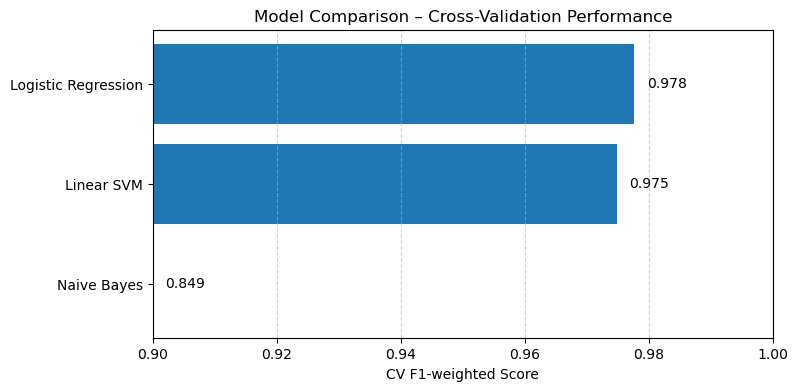

In [40]:
import matplotlib.pyplot as plt

# Sort values for better visualization
plot_df = results_df.sort_values(by="CV F1-weighted", ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(
    plot_df["Model"],
    plot_df["CV F1-weighted"]
)

plt.xlabel("CV F1-weighted Score")
plt.title("Model Comparison – Cross-Validation Performance")

plt.xlim(0.9, 1.0)
plt.grid(axis="x", linestyle="--", alpha=0.6)
for index, value in enumerate(plot_df["CV F1-weighted"]):
    plt.text(
        max(value, 0.90) + 0.002,
        index,
        f"{value:.3f}",
        va="center"
    )



plt.show()


In [41]:
import joblib

joblib.dump(
    pipelines["Logistic Regression"],
    "spam_classifier_pipeline.pkl"
)


['spam_classifier_pipeline.pkl']

### Final Model Selection

Logistic Regression was selected as the final model as it achieved the highest
cross-validated F1-weighted score while offering better interpretability and
stability compared to other linear models.
